In [1]:
import scipy.stats as stats
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("PAYROL_NY_STATE.csv")

In [3]:
df.head()

,NAME,OFFICE,TITLE,CITY,BIWEEKLT/HOURLY RATE,PAYROL TYPE,PAY PERIOD,LEGISLATIVE ENTITY
0,"ABBOT, JUDITH L",SENATOR TOBY ANN STAVISKY,COMMUNITY LIAISON,FLUSHING,1076.93,SA,4,SENATE EMPLOYEE
1,"ABREU, BRIAN A",LEGISLATIVE MESSENGER SERVICE,MESSENGER,ALBANY,1173.93,RA,4,JOINT LEGISLATIVE EMPLOYEE
2,"ABREU, TYDIE Z",SENATE FINANCE COMMITTEE/MAJORITY,SENIOR ANALYST,ALBANY,2692.31,RA,4,SENATE EMPLOYEE
3,"ACEVEDO, SAMANTHA I",SENATOR JESSICA RAMOS,SR. DIR. LEG. AFFRS / COMMITTEE DIR.,ALBANY,2307.70,RA,4,SENATE EMPLOYEE
4,"ADAMS, DAVID V",SENATE SERGEANT-AT-ARMS,SESSION SERGEANT-AT-ARMS,ALBANY,820.95,SA,4,SENATE EMPLOYEE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NAME                  1000 non-null   object 
 1   OFFICE                1000 non-null   object 
 2   TITLE                 1000 non-null   object 
 3   CITY                  1000 non-null   object 
 4   BIWEEKLT/HOURLY RATE  1000 non-null   float64
 5   PAYROL TYPE           1000 non-null   object 
 6   PAY PERIOD            1000 non-null   int64  
 7   LEGISLATIVE ENTITY    1000 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 62.6+ KB


In [5]:
df.shape

(1000, 8)

In [6]:
df["PAY PERIOD"].nunique()

1

In [7]:
for column in df.select_dtypes("object").columns:
    print(f"Column {column} has {df[column].nunique()} unique values.")

Column NAME has 1000 unique values.
Column OFFICE has 114 unique values.
Column TITLE has 429 unique values.
Column CITY has 55 unique values.
Column PAYROL TYPE has 3 unique values.
Column LEGISLATIVE ENTITY has 2 unique values.


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BIWEEKLT/HOURLY RATE,1000.0,2129.12208,1144.883266,11.1,1423.08,1923.08,2692.31,7115.39
PAY PERIOD,1000.0,4.00000,0.000000,4.0,4.00,4.00,4.00,4.00


In [9]:
pd.qcut(df['BIWEEKLT/HOURLY RATE'].sort_values(), q=4).value_counts()

(11.099, 1423.08]     253
(2692.31, 7115.39]    249
(1923.08, 2692.31]    249
(1423.08, 1923.08]    249
Name: BIWEEKLT/HOURLY RATE, dtype: int64

In [10]:
df[df['BIWEEKLT/HOURLY RATE'] < 200].shape

(37, 8)

In [11]:
df['BIWEEKLT/HOURLY RATE'] = df['BIWEEKLT/HOURLY RATE'].map(lambda x: x*80 if x<200 else x)

In [12]:
df.head()

,NAME,OFFICE,TITLE,CITY,BIWEEKLT/HOURLY RATE,PAYROL TYPE,PAY PERIOD,LEGISLATIVE ENTITY
0,"ABBOT, JUDITH L",SENATOR TOBY ANN STAVISKY,COMMUNITY LIAISON,FLUSHING,1076.93,SA,4,SENATE EMPLOYEE
1,"ABREU, BRIAN A",LEGISLATIVE MESSENGER SERVICE,MESSENGER,ALBANY,1173.93,RA,4,JOINT LEGISLATIVE EMPLOYEE
2,"ABREU, TYDIE Z",SENATE FINANCE COMMITTEE/MAJORITY,SENIOR ANALYST,ALBANY,2692.31,RA,4,SENATE EMPLOYEE
3,"ACEVEDO, SAMANTHA I",SENATOR JESSICA RAMOS,SR. DIR. LEG. AFFRS / COMMITTEE DIR.,ALBANY,2307.70,RA,4,SENATE EMPLOYEE
4,"ADAMS, DAVID V",SENATE SERGEANT-AT-ARMS,SESSION SERGEANT-AT-ARMS,ALBANY,820.95,SA,4,SENATE EMPLOYEE


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BIWEEKLT/HOURLY RATE,1000.0,2259.68459,1368.400309,230.77,1493.795,2000.0,2769.24,15384.8
PAY PERIOD,1000.0,4.00000,0.000000,4.00,4.000,4.0,4.00,4.0


In [14]:
df = df[~df['BIWEEKLT/HOURLY RATE'].transform(lambda x: abs(x-x.mean()) > 1.96*x.std()).values]

In [15]:
df.shape

(963, 8)

In [16]:
df.tail()

,NAME,OFFICE,TITLE,CITY,BIWEEKLT/HOURLY RATE,PAYROL TYPE,PAY PERIOD,LEGISLATIVE ENTITY
995,"SHROUT, JACKSON K",SENATOR TODD KAMINSKY,COMMUNITY LIAISON,ROCKVILLE CENTRE,1538.47,RA,4,SENATE EMPLOYEE
996,"SHUFON JR, ANTHONY A",SS/PRODUCTION SERVICES,DATA ANALYST,ALBANY,2180.24,RA,4,SENATE EMPLOYEE
997,"SHUTTER, WILLIAM J",SS/PRODUCTION SERVICES,MAILING OPERATOR II,ALBANY,1770.23,RA,4,SENATE EMPLOYEE
998,"SIERZEGA, KIMBERLY",SENATE TECHNOLOGY SERVICES,SENIOR OFFICE SUPPORT REPRESENTATIVE,ALBANY,2917.25,RA,4,SENATE EMPLOYEE
999,"SILVERSTEIN, CHARLES P",MINORITY COUNSEL/PROGRAM,LEGISLATIVE ANALYST,ALBANY,1923.08,RA,4,SENATE EMPLOYEE


In [17]:
df.reset_index(drop=True, inplace=True)

In [18]:
df.head()

,NAME,OFFICE,TITLE,CITY,BIWEEKLT/HOURLY RATE,PAYROL TYPE,PAY PERIOD,LEGISLATIVE ENTITY
0,"ABBOT, JUDITH L",SENATOR TOBY ANN STAVISKY,COMMUNITY LIAISON,FLUSHING,1076.93,SA,4,SENATE EMPLOYEE
1,"ABREU, BRIAN A",LEGISLATIVE MESSENGER SERVICE,MESSENGER,ALBANY,1173.93,RA,4,JOINT LEGISLATIVE EMPLOYEE
2,"ABREU, TYDIE Z",SENATE FINANCE COMMITTEE/MAJORITY,SENIOR ANALYST,ALBANY,2692.31,RA,4,SENATE EMPLOYEE
3,"ACEVEDO, SAMANTHA I",SENATOR JESSICA RAMOS,SR. DIR. LEG. AFFRS / COMMITTEE DIR.,ALBANY,2307.70,RA,4,SENATE EMPLOYEE
4,"ADAMS, DAVID V",SENATE SERGEANT-AT-ARMS,SESSION SERGEANT-AT-ARMS,ALBANY,820.95,SA,4,SENATE EMPLOYEE


In [19]:
df.columns = df.columns.str.capitalize()

In [20]:
df.head()

,Name,Office,Title,City,Biweeklt/hourly rate,Payrol type,Pay period,Legislative entity
0,"ABBOT, JUDITH L",SENATOR TOBY ANN STAVISKY,COMMUNITY LIAISON,FLUSHING,1076.93,SA,4,SENATE EMPLOYEE
1,"ABREU, BRIAN A",LEGISLATIVE MESSENGER SERVICE,MESSENGER,ALBANY,1173.93,RA,4,JOINT LEGISLATIVE EMPLOYEE
2,"ABREU, TYDIE Z",SENATE FINANCE COMMITTEE/MAJORITY,SENIOR ANALYST,ALBANY,2692.31,RA,4,SENATE EMPLOYEE
3,"ACEVEDO, SAMANTHA I",SENATOR JESSICA RAMOS,SR. DIR. LEG. AFFRS / COMMITTEE DIR.,ALBANY,2307.70,RA,4,SENATE EMPLOYEE
4,"ADAMS, DAVID V",SENATE SERGEANT-AT-ARMS,SESSION SERGEANT-AT-ARMS,ALBANY,820.95,SA,4,SENATE EMPLOYEE


In [21]:
for col in df.columns:
  print(f"{col} has {df[col].nunique()} unique items")
  if df[col].nunique() == 1 or df[col].nunique() == 963:
    print(f"\nyou can drop {col} feature \n")

Name has 963 unique items

you can drop Name feature 

Office has 112 unique items
Title has 406 unique items
City has 53 unique items
Biweeklt/hourly rate has 417 unique items
Payrol type has 3 unique items
Pay period has 1 unique items

you can drop Pay period feature 

Legislative entity has 2 unique items


In [22]:
df1 = df.drop(["Name", "Pay period"], axis= 1).copy()

In [23]:
df1.head()

,Office,Title,City,Biweeklt/hourly rate,Payrol type,Legislative entity
0,SENATOR TOBY ANN STAVISKY,COMMUNITY LIAISON,FLUSHING,1076.93,SA,SENATE EMPLOYEE
1,LEGISLATIVE MESSENGER SERVICE,MESSENGER,ALBANY,1173.93,RA,JOINT LEGISLATIVE EMPLOYEE
2,SENATE FINANCE COMMITTEE/MAJORITY,SENIOR ANALYST,ALBANY,2692.31,RA,SENATE EMPLOYEE
3,SENATOR JESSICA RAMOS,SR. DIR. LEG. AFFRS / COMMITTEE DIR.,ALBANY,2307.70,RA,SENATE EMPLOYEE
4,SENATE SERGEANT-AT-ARMS,SESSION SERGEANT-AT-ARMS,ALBANY,820.95,SA,SENATE EMPLOYEE


In [24]:
df1.Title.value_counts()

CHIEF OF STAFF                          43
COMMUNITY LIAISON                       43
LEGISLATIVE DIRECTOR                    28
ADMINISTRATIVE ASSISTANT                26
COMMUNICATIONS DIRECTOR                 23
                                        ..
LEGISLATIVE COMMITTEE DIRECTOR           1
INSURANCE COMM DR DPTY CHIEF OF STAF     1
DEPUTY ACCOUNTS PAYABLE MANAGER          1
BINDER OPERATIONS COORDINATOR            1
CALENDAR OPERATIONS COORDINATOR          1
Name: Title, Length: 406, dtype: int64

C:\Users\NIO\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


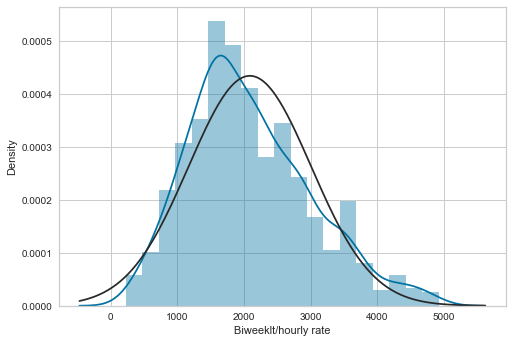

In [25]:
sns.distplot(df1["Biweeklt/hourly rate"], fit=stats.norm);

In [26]:
stats.skew(df1["Biweeklt/hourly rate"])

0.6036242553202789

In [27]:
list_of_least_title = []
for i in df1.Title.unique():
  if df.Title.value_counts()[i] < 2:
    list_of_least_title.append(i)

In [28]:
df1[df1.Title.isin(list_of_least_title)]

,Office,Title,City,Biweeklt/hourly rate,Payrol type,Legislative entity
3,SENATOR JESSICA RAMOS,SR. DIR. LEG. AFFRS / COMMITTEE DIR.,ALBANY,2307.70,RA,SENATE EMPLOYEE
10,SENATE TECHNOLOGY SERVICES,TECHNICAL SUPPORT REPRESENTATIVE,ALBANY,1307.70,RA,SENATE EMPLOYEE
13,SENATOR JESSICA RAMOS,DISTRICT POLICY & ORGANIZING DIRECTO,EAST ELMHURST,2000.00,RA,SENATE EMPLOYEE
20,MAJORITY CONFERENCE SERVICES,EXTERNAL RELATIONS LEGISLATIVE AIDE,ALBANY,2115.39,SA,SENATE EMPLOYEE
31,SENATOR SUSAN SERINO,DISTRICT OFFICE COORDINATOR,PUTNAM VALLEY,2307.70,RA,SENATE EMPLOYEE
...,...,...,...,...,...,...
947,SENATOR JAMES SANDERS,TEAM COUNSEL,ALBANY,2500.00,RA,SENATE EMPLOYEE
948,SENATOR ANNA M. KAPLAN,CHIEF OF STAFF/COUNSEL,ALBANY,4615.39,RA,SENATE EMPLOYEE
950,SENATE M&O/POST OFFICE,POSTMASTER,ALBANY,2628.45,RA,SENATE EMPLOYEE
952,MAJORITY COUNSEL/PROGRAM,POLICY ASSISTANT,ALBANY,1538.47,RA,SENATE EMPLOYEE


In [29]:
df1.head()

,Office,Title,City,Biweeklt/hourly rate,Payrol type,Legislative entity
0,SENATOR TOBY ANN STAVISKY,COMMUNITY LIAISON,FLUSHING,1076.93,SA,SENATE EMPLOYEE
1,LEGISLATIVE MESSENGER SERVICE,MESSENGER,ALBANY,1173.93,RA,JOINT LEGISLATIVE EMPLOYEE
2,SENATE FINANCE COMMITTEE/MAJORITY,SENIOR ANALYST,ALBANY,2692.31,RA,SENATE EMPLOYEE
3,SENATOR JESSICA RAMOS,SR. DIR. LEG. AFFRS / COMMITTEE DIR.,ALBANY,2307.70,RA,SENATE EMPLOYEE
4,SENATE SERGEANT-AT-ARMS,SESSION SERGEANT-AT-ARMS,ALBANY,820.95,SA,SENATE EMPLOYEE


In [30]:
df2 = pd.get_dummies(df1, drop_first=True)

In [31]:
df2.head()

,Biweeklt/hourly rate,Office_CH/DOCUMENT ROOM,Office_CH/JOURNAL CLERK'S OFFICE,Office_FO/ACCOUNTS PAYABLE,Office_FO/PAYROLL,Office_LC/DEVELOPMENT OF RURAL RESOURCES,Office_LC/LEGISLATIVE ETHICS COMMISSION,Office_LEGISLATIVE HEALTH SERVICE,Office_LEGISLATIVE LIBRARY,Office_LEGISLATIVE MESSENGER SERVICE,...,City_STATEN ISLAND,City_SYOSSET,City_SYRACUSE,City_UTICA,City_WATERTOWN,City_WILLIAMSVILLE,City_YONKERS,Payrol type_SA,Payrol type_TE,Legislative entity_SENATE EMPLOYEE
0,1076.93,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,1173.93,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2692.31,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2307.70,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,820.95,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [32]:
def print_evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

In [33]:
X = df2.drop("Biweeklt/hourly rate", axis=1)
y = df2["Biweeklt/hourly rate"]

In [34]:
X.shape

(963, 571)

In [35]:
y.shape

(963,)

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
lin_model = LinearRegression()

In [40]:
lin_model.fit(X_train, y_train)

LinearRegression()

In [41]:
lin_model.score(X_test,y_test)

-2.5475641853162458e+26

In [42]:
lin_model.score(X_train, y_train)

0.928085827943302

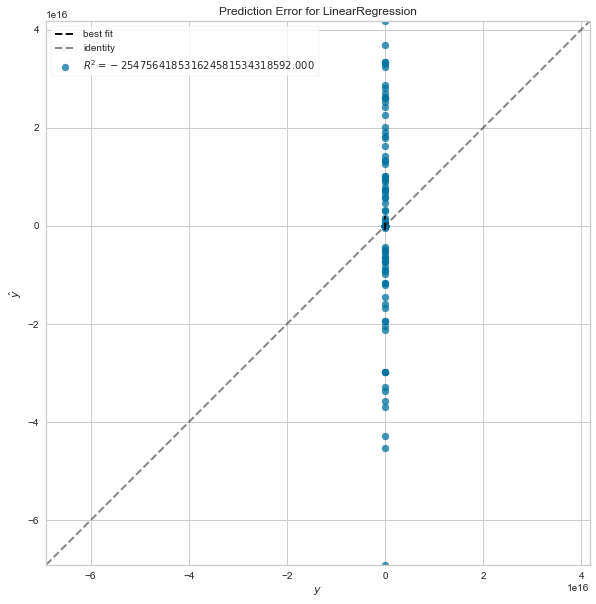

In [43]:
plt.figure(figsize=(10, 10))
visualizer = PredictionError(LinearRegression())
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

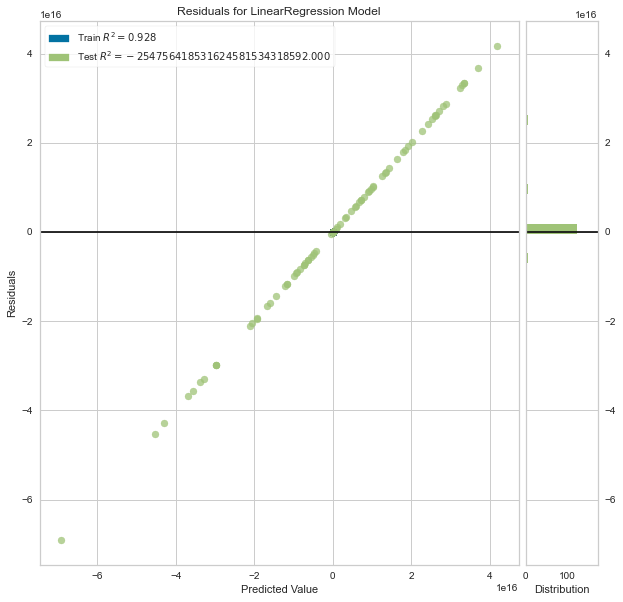

In [44]:
plt.figure(figsize=(10, 10))
model = ResidualsPlot(LinearRegression())
model.fit(X_train, y_train)
model.score(X_test, y_test)
model.show();

## Ridge Regression

In [45]:
from sklearn.linear_model import Ridge, RidgeCV

In [46]:
ridge_model = Ridge(random_state=42)

In [47]:
ridge_model.fit(X_train, y_train)

Ridge(random_state=42)

In [48]:
ridge_model.score(X_train,y_train)

0.849483100030242

In [49]:
ridge_model.score(X_test,y_test)

0.3699609114390163

In [50]:
scores = cross_validate(Ridge(), X_train, y_train, scoring=['r2',
                                                          'neg_mean_absolute_error',
                                                          'neg_mean_squared_error',
                                                          'neg_root_mean_squared_error'], cv=10)

In [51]:
pd.DataFrame(scores)

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.022005,0.007001,0.691615,-370.774048,-231209.109476,-480.842084
1,0.020005,0.007003,0.431356,-536.915009,-480272.490063,-693.016948
2,0.022005,0.006002,0.568630,-478.844679,-445130.704573,-667.181163
3,0.018750,0.000000,0.488462,-456.689719,-453469.392575,-673.401361
4,0.015624,0.015627,0.415478,-525.400082,-488315.943831,-698.796067
5,0.015626,0.000000,0.563989,-500.261000,-401382.791047,-633.547781
6,0.031254,0.000000,0.517789,-477.275000,-445218.497419,-667.246954
7,0.021674,0.000000,0.463081,-523.230823,-504730.050768,-710.443559
8,0.020094,0.010064,0.541121,-408.945232,-318844.818359,-564.663456
9,0.018096,0.002018,0.596816,-423.378331,-311607.992249,-558.218588


In [52]:
pd.DataFrame(scores).test_r2.mean()

0.5278337115763034

## Alpha Tuning

In [53]:
alpha_space = np.linspace(0.01, 20, 300)

In [54]:
ridgecv = RidgeCV(alphas = alpha_space,cv=10)

In [55]:
ridgecv.fit(X_train,y_train)

RidgeCV(alphas=array([1.00000000e-02, 7.68561873e-02, 1.43712375e-01, 2.10568562e-01,
       2.77424749e-01, 3.44280936e-01, 4.11137124e-01, 4.77993311e-01,
       5.44849498e-01, 6.11705686e-01, 6.78561873e-01, 7.45418060e-01,
       8.12274247e-01, 8.79130435e-01, 9.45986622e-01, 1.01284281e+00,
       1.07969900e+00, 1.14655518e+00, 1.21341137e+00, 1.28026756e+00,
       1.34712375e+00, 1.41397993e+0...
       1.84623077e+01, 1.85291639e+01, 1.85960201e+01, 1.86628763e+01,
       1.87297324e+01, 1.87965886e+01, 1.88634448e+01, 1.89303010e+01,
       1.89971572e+01, 1.90640134e+01, 1.91308696e+01, 1.91977258e+01,
       1.92645819e+01, 1.93314381e+01, 1.93982943e+01, 1.94651505e+01,
       1.95320067e+01, 1.95988629e+01, 1.96657191e+01, 1.97325753e+01,
       1.97994314e+01, 1.98662876e+01, 1.99331438e+01, 2.00000000e+01]),
        cv=10)

In [56]:
ridgecv.best_score_

0.5284042000334059

In [57]:
ridgecv.alpha_

1.2134113712374581

In [58]:
ridgecv.score(X_train,y_train)

0.8345220419861045

In [59]:
ridgecv.score(X_test,y_test)

0.36962502932487085

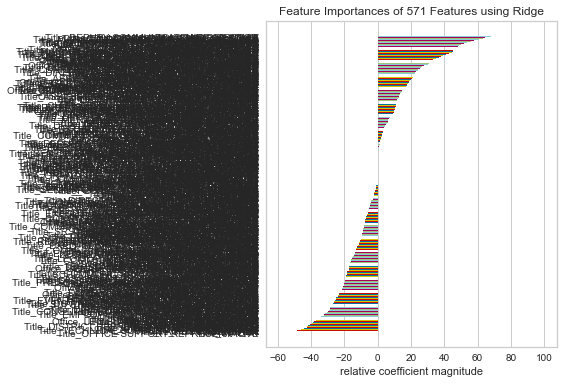

In [60]:
viz = FeatureImportances(Ridge(alpha=ridgecv.alpha_, random_state=42), labels=X.columns)
viz.fit(X_train, y_train)
viz.show();

In [61]:
y_pred = ridgecv.predict(X_test)

C:\Users\NIO\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


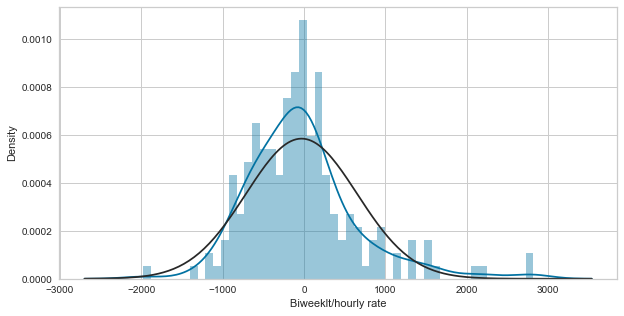

In [62]:
plt.figure(figsize=(10, 5))
sns.distplot((y_test - y_pred), bins=50, fit=stats.norm);

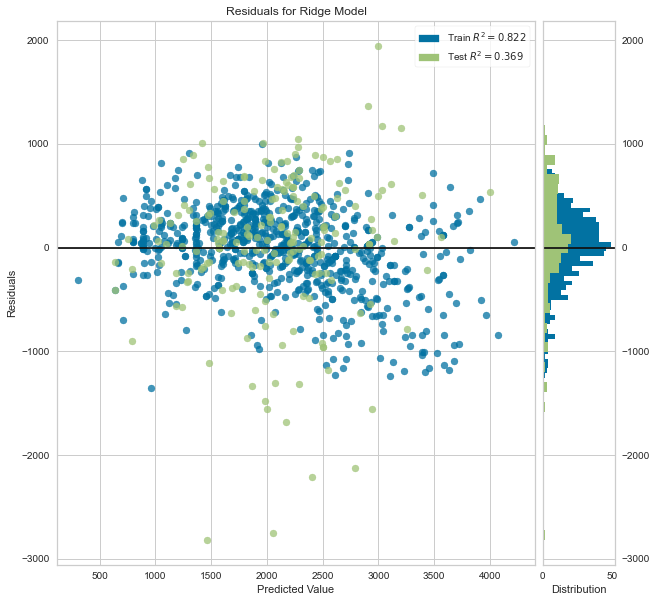

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [63]:
plt.figure(figsize=(10, 10))
model = ResidualsPlot(Ridge(alpha=1.414, random_state=42))
model.fit(X_train, y_train)
model.score(X_test, y_test)
model.show()

## LASSO Regression

In [64]:
from sklearn.linear_model import Lasso, LassoCV

In [65]:
lasso_model = Lasso()

In [66]:
lasso_model.fit(X_train,y_train)

Lasso()

In [67]:
lasso_model.score(X_train,y_train)

0.7823697667590425

In [68]:
lasso_model.score(X_test,y_test)

0.34508278440808093

In [69]:
scores = cross_validate(Lasso(random_state=42), X_train, y_train, scoring=['r2',
                                                          'neg_mean_absolute_error',
                                                          'neg_mean_squared_error',
                                                          'neg_root_mean_squared_error'], cv=10)

In [70]:
pd.DataFrame(scores)

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.014003,0.005001,0.718153,-368.244571,-211312.530640,-459.687427
1,0.016004,0.006001,0.409856,-554.501431,-498431.616180,-705.996895
2,0.023006,0.006001,0.542147,-506.954329,-472459.070815,-687.356582
3,0.017004,0.006001,0.436698,-477.392641,-499357.495211,-706.652316
4,0.016004,0.005001,0.365513,-561.525939,-530058.079416,-728.050877
5,0.015003,0.005001,0.587852,-475.459911,-379415.239619,-615.966914
6,0.017004,0.005001,0.457776,-516.439232,-500627.159187,-707.550111
7,0.016004,0.005001,0.379154,-554.735753,-583625.585610,-763.953916
8,0.014003,0.005001,0.501041,-442.879757,-346693.555368,-588.806891
9,0.016004,0.005002,0.557860,-440.099454,-341715.632904,-584.564481


In [71]:
pd.DataFrame(scores).test_r2.mean()

0.4956048610289403

In [72]:
lasso_cv_model = LassoCV(alphas = alpha_space, cv=10, max_iter=100000, n_jobs =-1, random_state=42).fit(X_train, y_train)

In [73]:
lasso_cv_model.alpha_

0.8122742474916388

In [74]:
lasso_cv_model.score(X_train,y_train)

0.8135192860443252

In [75]:
lasso_cv_model.score(X_test,y_test)

0.35556318161579314

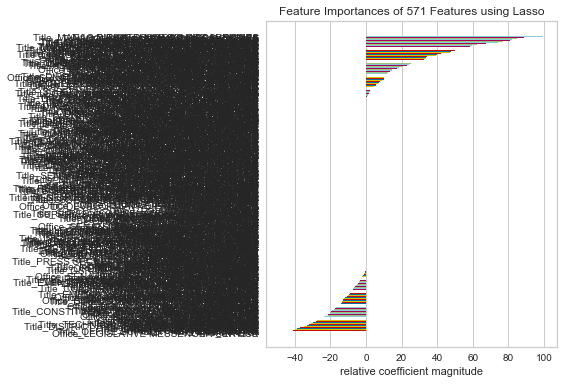

In [76]:
viz = FeatureImportances(Lasso(alpha=lasso_cv_model.alpha_, random_state=42), labels=X.columns)
viz.fit(X_train, y_train)
viz.show();

## Elastic Net

In [77]:
from sklearn.linear_model import ElasticNet, ElasticNetCV

In [78]:
elm = ElasticNet(alpha=0.1, l1_ratio=0.9, selection="random", random_state=42)

In [79]:
elm.fit(X_train,y_train)

ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=42, selection='random')

In [80]:
elm.score(X_train,y_train)

0.6302576586179983

In [81]:
elm.score(X_test,y_test)

0.31930731289999614

In [82]:
grid_params = {'alpha':alpha_space, 'l1_ratio':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [83]:
grid = GridSearchCV(ElasticNet(random_state=42), param_grid=grid_params, n_jobs=-1, verbose=2, cv=10)

In [84]:
grid.fit(X_train,y_train)

Fitting 10 folds for each of 2700 candidates, totalling 27000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 3692 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 5472 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 7580 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 10008 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 12764 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 15840 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done 19244 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 22968 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 27000 out of 27000 | elapsed:  1.5min finished


GridSearchCV(cv=10, estimator=ElasticNet(random_state=42), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-02, 7.68561873e-02, 1.43712375e-01, 2.10568562e-01,
       2.77424749e-01, 3.44280936e-01, 4.11137124e-01, 4.77993311e-01,
       5.44849498e-01, 6.11705686e-01, 6.78561873e-01, 7.45418060e-01,
       8.12274247e-01, 8.79130435e-01, 9.45986622e-01, 1.01284281e+00,
       1.07969900e+00, 1...
       1.87297324e+01, 1.87965886e+01, 1.88634448e+01, 1.89303010e+01,
       1.89971572e+01, 1.90640134e+01, 1.91308696e+01, 1.91977258e+01,
       1.92645819e+01, 1.93314381e+01, 1.93982943e+01, 1.94651505e+01,
       1.95320067e+01, 1.95988629e+01, 1.96657191e+01, 1.97325753e+01,
       1.97994314e+01, 1.98662876e+01, 1.99331438e+01, 2.00000000e+01]),
                         'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9]},
             verbose=2)

In [85]:
grid.best_params_

{'alpha': 0.01, 'l1_ratio': 0.8}

In [86]:
grid.best_score_

0.5281738555413359